# Optimizing Models Using ROC Graphs
This notebook presents a simple use-case of how a classification model can be optimized using a ROC graph. We'll be using the `roc_graph` method of `dython` [(link)](http://shakedzy.xyz/dython).

Note that due to the nature of `np.random.RandomState` which is used in this notebook, the output graphs may vary from one machine to another.

In [1]:
import random
import numpy as np
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, normalize
from sklearn.multiclass import OneVsRestClassifier
from dython.model_utils import roc_graph

## Binary Classification
We'll begin with a simple binary classification, where the label is either 0 or 1, or in other words, does a sample belong to the class or not. For this we'll use the Breast Cancer Dataset, which can be imported from `sklearn`. The target values here will be 0 = _malignant_ and 1 = _benign_.

In [2]:
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
print('Number of samples: {}'.format(y.size))

Number of samples: 569


We'll split the data half and half between training and data, and train a very weak Random Forest, which has only 5 trees with a maximum depth of 4. We're making it weak for the sake of the example - in real life, you'll probably want a wider and deeper forest.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
classifier = RandomForestClassifier(n_estimators=5, max_depth=4, random_state=0)
y_pred = classifier.fit(X_train, y_train).predict_proba(X_test)[:,1]

Let's see how good are the model's predictions:

In [4]:
y_p = np.vectorize(round)(y_pred)
s = 0
for i in range(y_test.size):
    if y_test[i] == y_p[i]:
        s += 1
print('Correct predictions: {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100*s/y_test.size))

Correct predictions: 266/285 (93.33%)


It's doing quite good, with 93.3% accuracy. Let's plot it's ROC graph and see if we can improve it a little more:

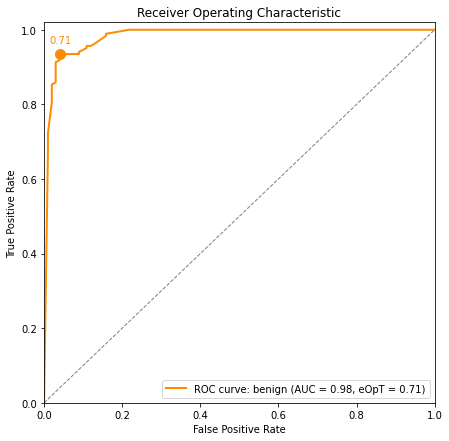

In [5]:
roc_graph(y_test, y_pred, class_names=breast_cancer.target_names, figsize=(7,7))

Not surprisingly, the AUC score of this model is very high. But is there anything we can do to make its predictions more accurate?

Well, yes - we can adjust the class prediction threshold. Remeber that the default is to assign a sample to the _benign_ class if its model's prediction confidence (or predicted probability) is 0.5 or more. But as we can see from the ROC graph plot, the estimated optimal threshold (`eOpT`) is 0.71. This means we should assign the _benign_ class to a sample only if the model's predicted probability is higher than that.

Let's reconfigure the model's threshold and see its performace now:

In [6]:
y_p = np.vectorize(lambda x: 1 if x >= .71 else 0)(y_pred)
s = 0
for i in range(y_test.size):
    if y_test[i] == y_p[i]:
        s += 1
print('Correct predictions: {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100.0*s/y_test.size))

Correct predictions: 269/285 (94.39%)


Not bad! We improved the accuracy of the model by another 1% just by selecting a different prediction threshold!

## ROC Curves of a Perfect Classifier
Let's examine the case of a perfect binary classifier, but which is skewed. In this example, all Positive samples will have a predicted probability of 0.8 or more, and all Negative samples will have a predicted probability of less than 0.8.

Let's begin with creating some synthetic data:

In [7]:
random.seed(0)
y_test = np.vectorize(lambda _: random.randint(0,1))(np.zeros(100))
y_pred = np.vectorize(lambda x: random.uniform(0.,.799) if x == 0 else random.uniform(.8,1.))(y_test)

Let's plot the model's ROC graph:

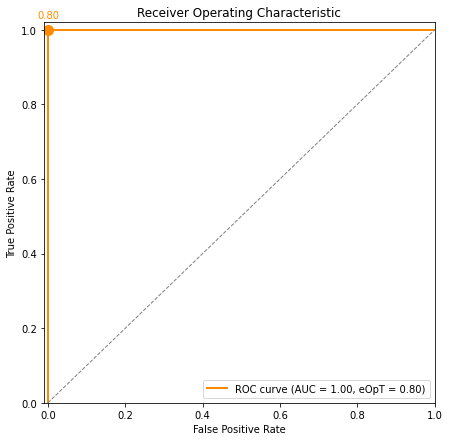

In [8]:
roc_graph(y_test, y_pred, xlim=(-.01,1), figsize=(7,7))

As expected, we see $AUC = 1$, and the estimated-optimal threshold is indeed what we set.

Let's first check how well does the default 0.5 threshold performs:

In [9]:
y_p = np.vectorize(round)(y_pred)
s = 0
for i in range(y_test.size):
    if y_test[i] == y_p[i]:
        s += 1
print('Correct predictions: {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100*s/y_test.size))

Correct predictions: 83/100 (83.00%)


While we know this is a perfect classifier, we only see 83% accuracy, due to the mere fact that our default threshold doesn't take into account the skewness of the model. 

Now let's try this again with the new threshold:

In [10]:
y_p = np.vectorize(lambda x: 1 if x >= .8 else 0)(y_pred)
s = 0
for i in range(y_test.size):
    if y_test[i] == y_p[i]:
        s += 1
print('Correct predictions: {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100.0*s/y_test.size))

Correct predictions: 100/100 (100.00%)


## Multi-Class Classification
Let's continue with a more complex case, where more than one class exists. We'll use the Iris Dataset for this, where three types of irises are found in the dataset. We'll follow a similar example found in [SciKit-Learn's documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).

In [11]:
iris = datasets.load_iris()
X = iris.data
y = label_binarize(iris.target, classes=[0, 1, 2])
print('Number of samples: {}'.format(X.shape[0]))

Number of samples: 150


We'll add some noisy features, to make this more challenging: 

In [12]:
random_state = np.random.RandomState(4)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]
print('Original number of features: {}, New number of features: {}'.format(n_features, X.shape[1]))

Original number of features: 4, New number of features: 804


Again, we'll split the data half and half amnong train-set and test-set. This time we'll use a SVM classifier:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=0))
y_pred = classifier.fit(X_train, y_train).predict_proba(X_test)
y_pred = normalize(y_pred, norm='l1')

Let's check the model's accuracy:

In [14]:
s = 0
for i in range(y_test.shape[0]):
    if y_test[i,:].argmax() == y_pred[i,:].argmax():
        s += 1
print('Correct predictions: {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100.0*s/y_test.size))

Correct predictions: 47/225 (20.89%)


Let's plot its ROC graph:

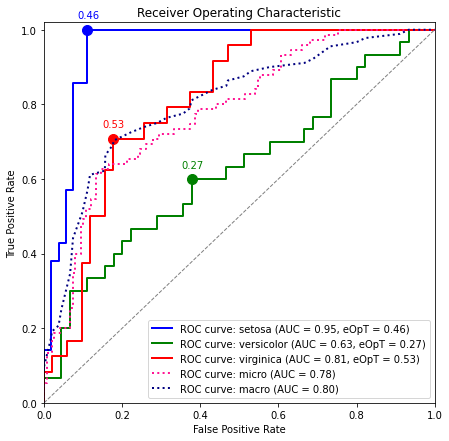

In [15]:
roc_graph(y_test, y_pred, class_names=iris.target_names, figsize=(7,7))

Now things get a little more complicated, as each class has its own estimated-optimal threshold. Let's try to consider all of those together:

In [16]:
s = 0
for i in range(y_test.shape[0]):
    if y_pred[i,2] >= .53: cls = 2
    elif y_pred[i,0] >= .46: cls = 0
    elif y_pred[i,1] >= .27: cls = 1
    else: cls = y_pred[i,:].argmax() # fallback
    if y_test[i,:].argmax() == cls:
        s += 1
print('Correct predictions: {0}/{1} ({2:.2f}%)'.format(s, y_test.size, 100.0*s/y_test.size))

Correct predictions: 52/225 (23.11%)


Not bad, accuracy improved by about 2.2% just by adjusting the thresholds. Note that in cases such as this, the order of `if/elif/else` matters, as technically more than one class can have a probability higher than its threshold. You'll have to fiddle with this in order to find the best order for your model.